In [1]:
import torch
import matplotlib.pyplot as plt
from Gibbs import generate_sw_tuples_batch
from MINE import MINE_1
from tqdm import tqdm
from torch.autograd import Variable
import numpy as np
from Sample_Gibbs_from_Gaussian import sample_w
from Sample_Gibbs_from_Gaussian import log_P
import random
import os
def seed_torch(seed=1029):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True
seed_torch()

p_current = 28 #p值
sample_size = 50000 #用来估计的样本数
iter_size = 27000
beta = 10
sigma_q = 0.5
model = MINE_1(p_current)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []



In [2]:
'''
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available
            else "cpu")

print(device)

model = torch.load('./model_kl_4.pth')
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
'''

'\nif torch.cuda.is_available():\n  torch.set_default_tensor_type(torch.cuda.FloatTensor)\n  print("using cuda:", torch.cuda.get_device_name(0))\n  pass\n\ndevice = torch.device("cuda" if torch.cuda.is_available\n            else "cpu")\n\nprint(device)\n\nmodel = torch.load(\'./model_kl_4.pth\')\noptimizer = torch.optim.Adam(model.parameters(), lr=0.02)\n'

100%|██████████| 500/500 [7:23:39<00:00, 53.24s/it]  


0.7151103019714355

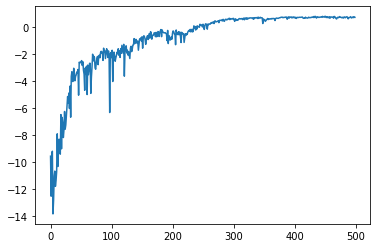

In [3]:
################################################################
original_random_state = np.random.get_state()
np.random.seed(20230929)
#gaussian distribution sampler: normal(mean=0.0, variance_sqrt=1.0, size=None) s = np.random.normal(0,1)
#teacher model
#dimension of x: d（固定不变）10->5
d = 5
#number of training samples（固定不变）100->20
N = 20
#dimension of hypothesis space
p0 = 5 #dimension of teacher model（固定不变）
p = p_current #dimension of student model（可变）#p=200
p_max = 2000 #upper bound of dimension of student model（固定不变）
#point-wise activate function f:tanh
#variance of random noise added to y
sigma = 0.1

#random feature matrix
F0 = np.random.normal(0,1,(d,p0)) #生成teacher model的random feature matrix F0（固定不变）
F = np.random.normal(0,1,(d,p_max))[:,:p] #生成student model的random feature matrix F(d*p)。先按照p_max的大小生成，再根据当前维度p的不同截取前p列形成每个p对应的F。
    #注意，这个F对于一般的神经网络是可训练的，但是对于RFM为了简化直接设定为固定值。（固定不变）
#teacher parameter w(p) with lambda = ? until each dim of Y~1e0
lambda_ = 0.0001
#w_0 = np.random.normal(0,sigma/np.sqrt(lambda_*N),p)
w_0 = np.random.normal(0,1,p0) #生成teacher model的权重向量（固定不变）
#w_0 = np.concatenate((w_0,np.zeros(5)),axis = 0)

np.random.set_state(original_random_state)
################################################################
kl = []
num_epoch = 500
for epoch in tqdm(range(num_epoch)):
    w = []
    log_P_wCs = []
    log_P_wCs_shuffled = []
    B = []
    Y = []
    for i in range(iter_size):
        X = np.random.normal(0,1,(N,d))
        X_rf0 = np.tanh(X.dot(F0)/np.sqrt(d))
        Y_pure = X_rf0.dot(w_0)
        Y_i = Y_pure + np.random.normal(0,sigma,N) #由X通过teacher model（也就是F0和w_0）生成的Y
        #S_i = np.concatenate((X,Y_i.reshape(N,-1)),axis=1).reshape(-1)  #S=(X,Y)[0]
        B_i = np.tanh(X.dot(F)/np.sqrt(d))
        w_i = sample_w(p,N,beta,sigma_q,B_i,Y_i,1)[0]##===>
        log_P_wCs.append(log_P(w_i,B_i,Y_i,N,beta,sigma_q))##===>
        w.append(w_i)
        B.append(B_i)
        Y.append(Y_i)
    w = np.array(w)
    log_P_wCs = np.array(log_P_wCs)
    j = 0
    for i in np.random.permutation(range(iter_size)):
        log_P_wCs_shuffled.append(log_P(w[j],B[i],Y[i],N,beta,sigma_q))##===>
        j+=1
    log_P_wCs_shuffled = np.array(log_P_wCs_shuffled)
    w_sample = Variable(torch.from_numpy(w).type(torch.FloatTensor), requires_grad=False)
    log_P_wCs = Variable(torch.from_numpy(log_P_wCs).reshape(-1,1).type(torch.FloatTensor), requires_grad=False)
    log_P_wCs_shuffled = Variable(torch.from_numpy(log_P_wCs_shuffled).reshape(-1,1).type(torch.FloatTensor), requires_grad=False)
    T_w = model(w_sample)
    
    loss1 = - torch.mean(-log_P_wCs_shuffled+T_w)
    loss2 = torch.log(torch.mean(torch.exp(-log_P_wCs+T_w)))
    loss = (loss1 + loss2)
    #res = torch.mean(log_P_wCs-T_w-(log_P_wCs_shuffled-T_w))
    kl.append((-loss).data.cpu().numpy().item())
    model.zero_grad()
    loss.backward()
    optimizer.step()

x_plot = [x for x in range(num_epoch)]
plt.plot(x_plot, kl)
################################################################################################
import json
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
with open("kl_result/p=4_gaussian_full_beta=10.json", "w") as outfile:
    outfile.write(json.dumps(kl,cls=NumpyArrayEncoder))
################################################################################################
kl[len(kl)-1]

In [4]:
np.mean(kl[360:])

0.6967563833509173

In [5]:
np.mean(kl[300:])

0.6677202486991882

In [6]:
np.mean(kl[250:])

0.6105313558578491

In [7]:
np.mean(kl[200:])

0.4518257941802343

In [8]:
T_w = model(w_sample)
res = torch.mean(log_P_wCs-T_w-(log_P_wCs_shuffled-T_w))
#res = -torch.log(torch.mean(torch.exp(log_P_wCs_shuffled-T_w)))+(-torch.log(torch.mean(torch.exp(-log_P_wCs+T_w))))
res

tensor(1.5363, grad_fn=<MeanBackward0>)

每一个的很奇怪，但是合起来就是正确的值！

In [9]:
torch.save(model,'pw_res/model_lk_b=10_s=0.5_p={0}.pth'.format(p_current))

L:

(20,0.5235753059387207)
(21,0.6030466437339783)
(22,0.5971028077602386)